# ESPEI

### Extensible Self-optimizating Phase Equilibria Infrastructure

Documentation for internal and external APIs can be found at https://espei.org

Solutions to this notebook can be found at https://github.com/materialsgenomefoundation/2023-workshop-material

## Markov Chain Monte Carlo (MCMC)

### Running MCMC

The most minimal MCMC settings file that could be used for ESPEI only requires setting the source of the database (i.e. the database from parameter selection) and the number of iterations.

```yaml
system:
  phase_models: phases.json
  datasets: input-data/run
output:
  output_db:  mcmc.tdb
  verbosity:  2
mcmc:
  iterations: 100
  input_db: generated.tdb
```

By default, ESPEI will run in parallel using the `dask` package. If you try to run this locally, you may need to do an [extra step to configure dask](https://espei.org/en/latest/installation.html#configuration).

However, since we are using limited and shared cloud resources, we will make some compromises in terms of accuracy and storage. The settings we'll use for running MCMC simulations are as follows (saved as `mcmc_settings.yaml`):

```yaml
system:
  phase_models: ../phase_models.json      # path to the phases file
  datasets: ../input-data  # path to the directory containing input data
  tags:
    dft:
      excluded_model_contributions: ['idmix', 'mag']
    estimated-entropy:
      excluded_model_contributions: ['idmix', 'mag']
output:
  output_db: Cu-Mg-mcmc.tdb               # what to name the output TDB file
  verbosity: 1                            # levels of verbosity. Choose 0, 1 or 2 for Warnings, Info, or Debug
  tracefile: null  # don't write out this file
  probfile:  null  # don't write out this file
  logfile:   null  # write output to console
mcmc:
  iterations: 2
  save_interval: 1
  scheduler: null  # don't parallelize, just run on one core
  input_db: Cu-Mg-generated.tdb
  prior:
    name: normal
    loc_relative: 1.0
    scale_relative: 1.0
```

All MCMC options are explained in [ESPEI's YAML settings file documentation](https://espei.org/en/latest/writing_input.html#mcmc). Compared to parameter generation, the options are more extensive and worth being familiar with.

In [1]:
import yaml
from espei import run_espei
from pycalphad import Database, binplot, equilibrium, variables as v

In [2]:
with open('mcmc_settings.yaml') as fp:
    mcmc_settings = yaml.safe_load(fp)

Now we'll run the MCMC simulation for just two iterations. The outputs are the database which has the most optimal parameters of all samples and an `emcee.EnsembleSampler` object that contains the trace (contains samples of the parameters for every chain and iteration) and the log-likelihood.

In [3]:
dbf_mcmc, sampler = run_espei(mcmc_settings)

INFO:espei.espei_script - espei version       0.8.9.dev3+g5fafe45
INFO:espei.espei_script - If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
TRACE:espei.espei_script - Loading and checking datasets.
TRACE:espei.espei_script - Finished checking datasets
INFO:espei.espei_script - Not using a parallel scheduler. ESPEI is running MCMC on a single core.
INFO:espei.error_functions.context - Fitting 22 degrees of freedom.
TRACE:espei.error_functions.context - Building phase models (this may take some time)
TRACE:espei.error_functions.context - Finished building phase models (0.42s)
TRACE:espei.error_functions.context - Getting non-equilibrium thermochemical data (this may take some time)
/Users/brandon/

The key output from the sampler are the trace (`emcee` calls this the "chain") and the log-probability (lnprob). The trace has the shape `(number of chains, number of iterations, number of parameters)`. The log-probability has the shape  `(number of chains, number of iterations)`.



In [4]:
trace = sampler.chain
lnprob = sampler.lnprobability

print(f"Trace shape:           {trace.shape}")
print(f"Log-probability shape: {lnprob.shape}")

Trace shape:           (44, 2, 22)
Log-probability shape: (44, 2)


With the MCMC simulation complete, we can see what the phase diagram looks like.

In [5]:
from espei.plot import dataplot
from espei.datasets import recursive_glob, load_datasets

# load our JSON datasets into an in-memory database
datasets = load_datasets(recursive_glob('../input-data', '*.json'))

<AxesSubplot:title={'center':'CU-MG'}, xlabel='X(MG)', ylabel='Temperature (K)'>

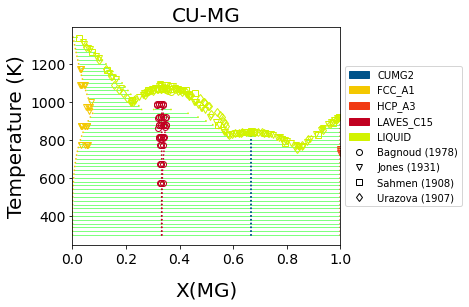

In [6]:
dbf_start = Database('Cu-Mg-generated.tdb')
comps = ['CU', 'MG']
phases = ['FCC_A1', 'HCP_A3', 'LIQUID', 'CUMG2', 'LAVES_C15']
conds = {v.N: 1.0, v.P: 101325, v.T: (300, 2300, 20), v.X('MG'): (0, 1, 0.02)}
ax = binplot(dbf_start, comps, phases, conds)
dataplot(comps, phases, conds, datasets, ax=ax)

<AxesSubplot:title={'center':'CU-MG'}, xlabel='X(MG)', ylabel='Temperature (K)'>

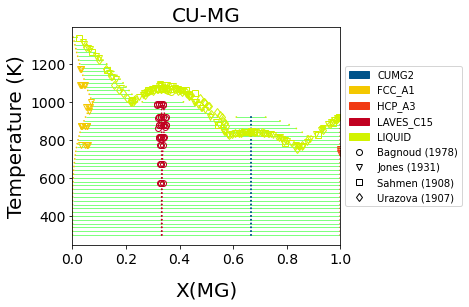

In [7]:
comps = ['CU', 'MG']
phases = ['FCC_A1', 'HCP_A3', 'LIQUID', 'CUMG2', 'LAVES_C15']
conds = {v.N: 1.0, v.P: 101325, v.T: (300, 2300, 20), v.X('MG'): (0, 1, 0.02)}
ax = binplot(dbf_mcmc, comps, phases, conds)
dataplot(comps, phases, conds, datasets, ax=ax)

After just a few MCMC iterations through 44 chains, the phase diagram shows a small change.

### Simulated MCMC analysis

Typically, a fully converged MCMC simulation with enough samples to do uncertainty quantification will require a few hundred to a few thousand calculations. 


Since performing an MCMC simulation for a significant period of time is not possible in this workshop, an existing pre-computed trace and log-probability are loaded that took 1000 iterations of sampling 40 chains for a total of 40,000 samples in parameter space. These 40,000 samples took 3.5 hours to run across 6 cores on a 2015 MacBook Pro (2.2 GHz Intel i7).


In [8]:
import numpy as np
from espei.analysis import truncate_arrays

In [9]:
trace = np.load('trace.npy')
lnprob = np.load('lnprob.npy')

trace, lnprob = truncate_arrays(trace, lnprob)

print(trace.shape)
print(lnprob.shape)

(88, 2000, 22)
(88, 2000)


#### Visualizing convergence of the simulation

(-5000.0, -4500.0)

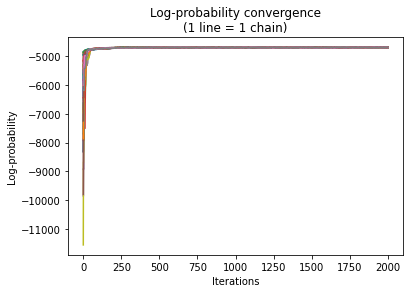

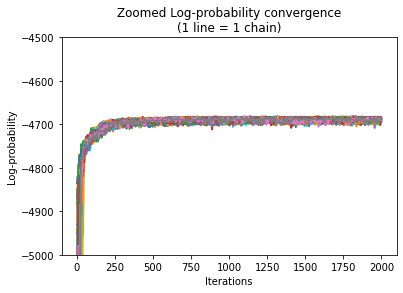

In [10]:
import matplotlib.pyplot as plt
plt.plot(lnprob.T)
plt.title('Log-probability convergence\n(1 line = 1 chain)')
plt.xlabel('Iterations')
plt.ylabel('Log-probability')

plt.figure()
plt.plot(lnprob.T)
plt.title('Zoomed Log-probability convergence\n(1 line = 1 chain)')
plt.xlabel('Iterations')
plt.ylabel('Log-probability')
plt.ylim(-5000, -4500)

#### Visualizing change in a particular parameter

Text(0.5, 1.0, 'Parameter Convergence')

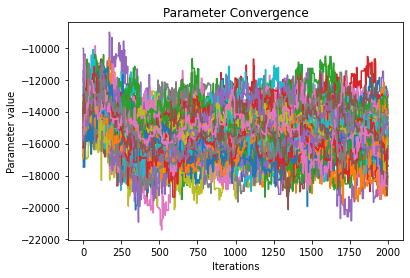

In [11]:
# index of parameter of interest within the chain
# could be looped to produce figures for all parameters
parameter_idx = 5

num_chains = trace.shape[0]
ax = plt.figure().gca()
ax.set_xlabel('Iterations')
ax.set_ylabel('Parameter value')
ax.plot(trace[..., parameter_idx].T)
ax.set_title('Parameter Convergence')

#### Finding the optimal set of parameters and plotting the phase diagram

An MCMC simulation has many samples, but we are still likely interested in getting the set of parameters that's the best point estimate of the data.

ESPEI provides an `optimal_parameters` function that will extract the parameter set with the highest log-probability, which can be used to update the symbols that we fit in the database ($ \mathrm{VV0001} $, ...)..

In [12]:
from espei.utils import database_symbols_to_fit, optimal_parameters
import copy

# make an in-memory copy of the database because updating the
# symbols with the optimal solutions will erase the old ones
dbf_opt = copy.deepcopy(dbf_mcmc)

# Find the optimal parameters and replace the values in the symbols dictionary
opt_params = dict(zip(database_symbols_to_fit(dbf_opt), optimal_parameters(trace, lnprob)))
dbf_opt.symbols.update(opt_params)

<AxesSubplot:title={'center':'CU-MG'}, xlabel='X(MG)', ylabel='Temperature (K)'>

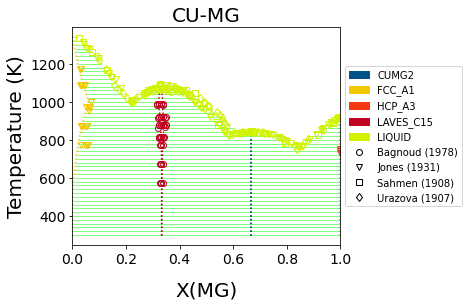

In [13]:
# plot the phase diagram

ax = binplot(dbf_opt, comps, phases, conds)
dataplot(comps, phases, conds, datasets, ax=ax)